In [1]:
import math
import numpy as np
import pandas as pd
import os
import subprocess
from tqdm import tqdm
import time
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Carrega arquivo parquet
df = pd.read_parquet("DB/List-dependencies.parquet")

In [3]:
dfs = {}
graphs = {}
dfs["Geral"] = df
graphs["Geral"] = nx.from_pandas_edgelist(df, source="Project Name", target="Dependency Name", create_using=nx.DiGraph())
for platform in df["Platform"].unique():
    # cria um dataframe para cada plataforma "df["Platform"].unique()" e adiciona a lista de dataframes ao dicionário "dfs"
    dfs[platform] = df[df["Platform"] == platform]

    # Cria um grafo direcionado
    graphs[platform] = nx.from_pandas_edgelist(dfs[platform], source="Project Name", target="Dependency Name", create_using=nx.DiGraph())

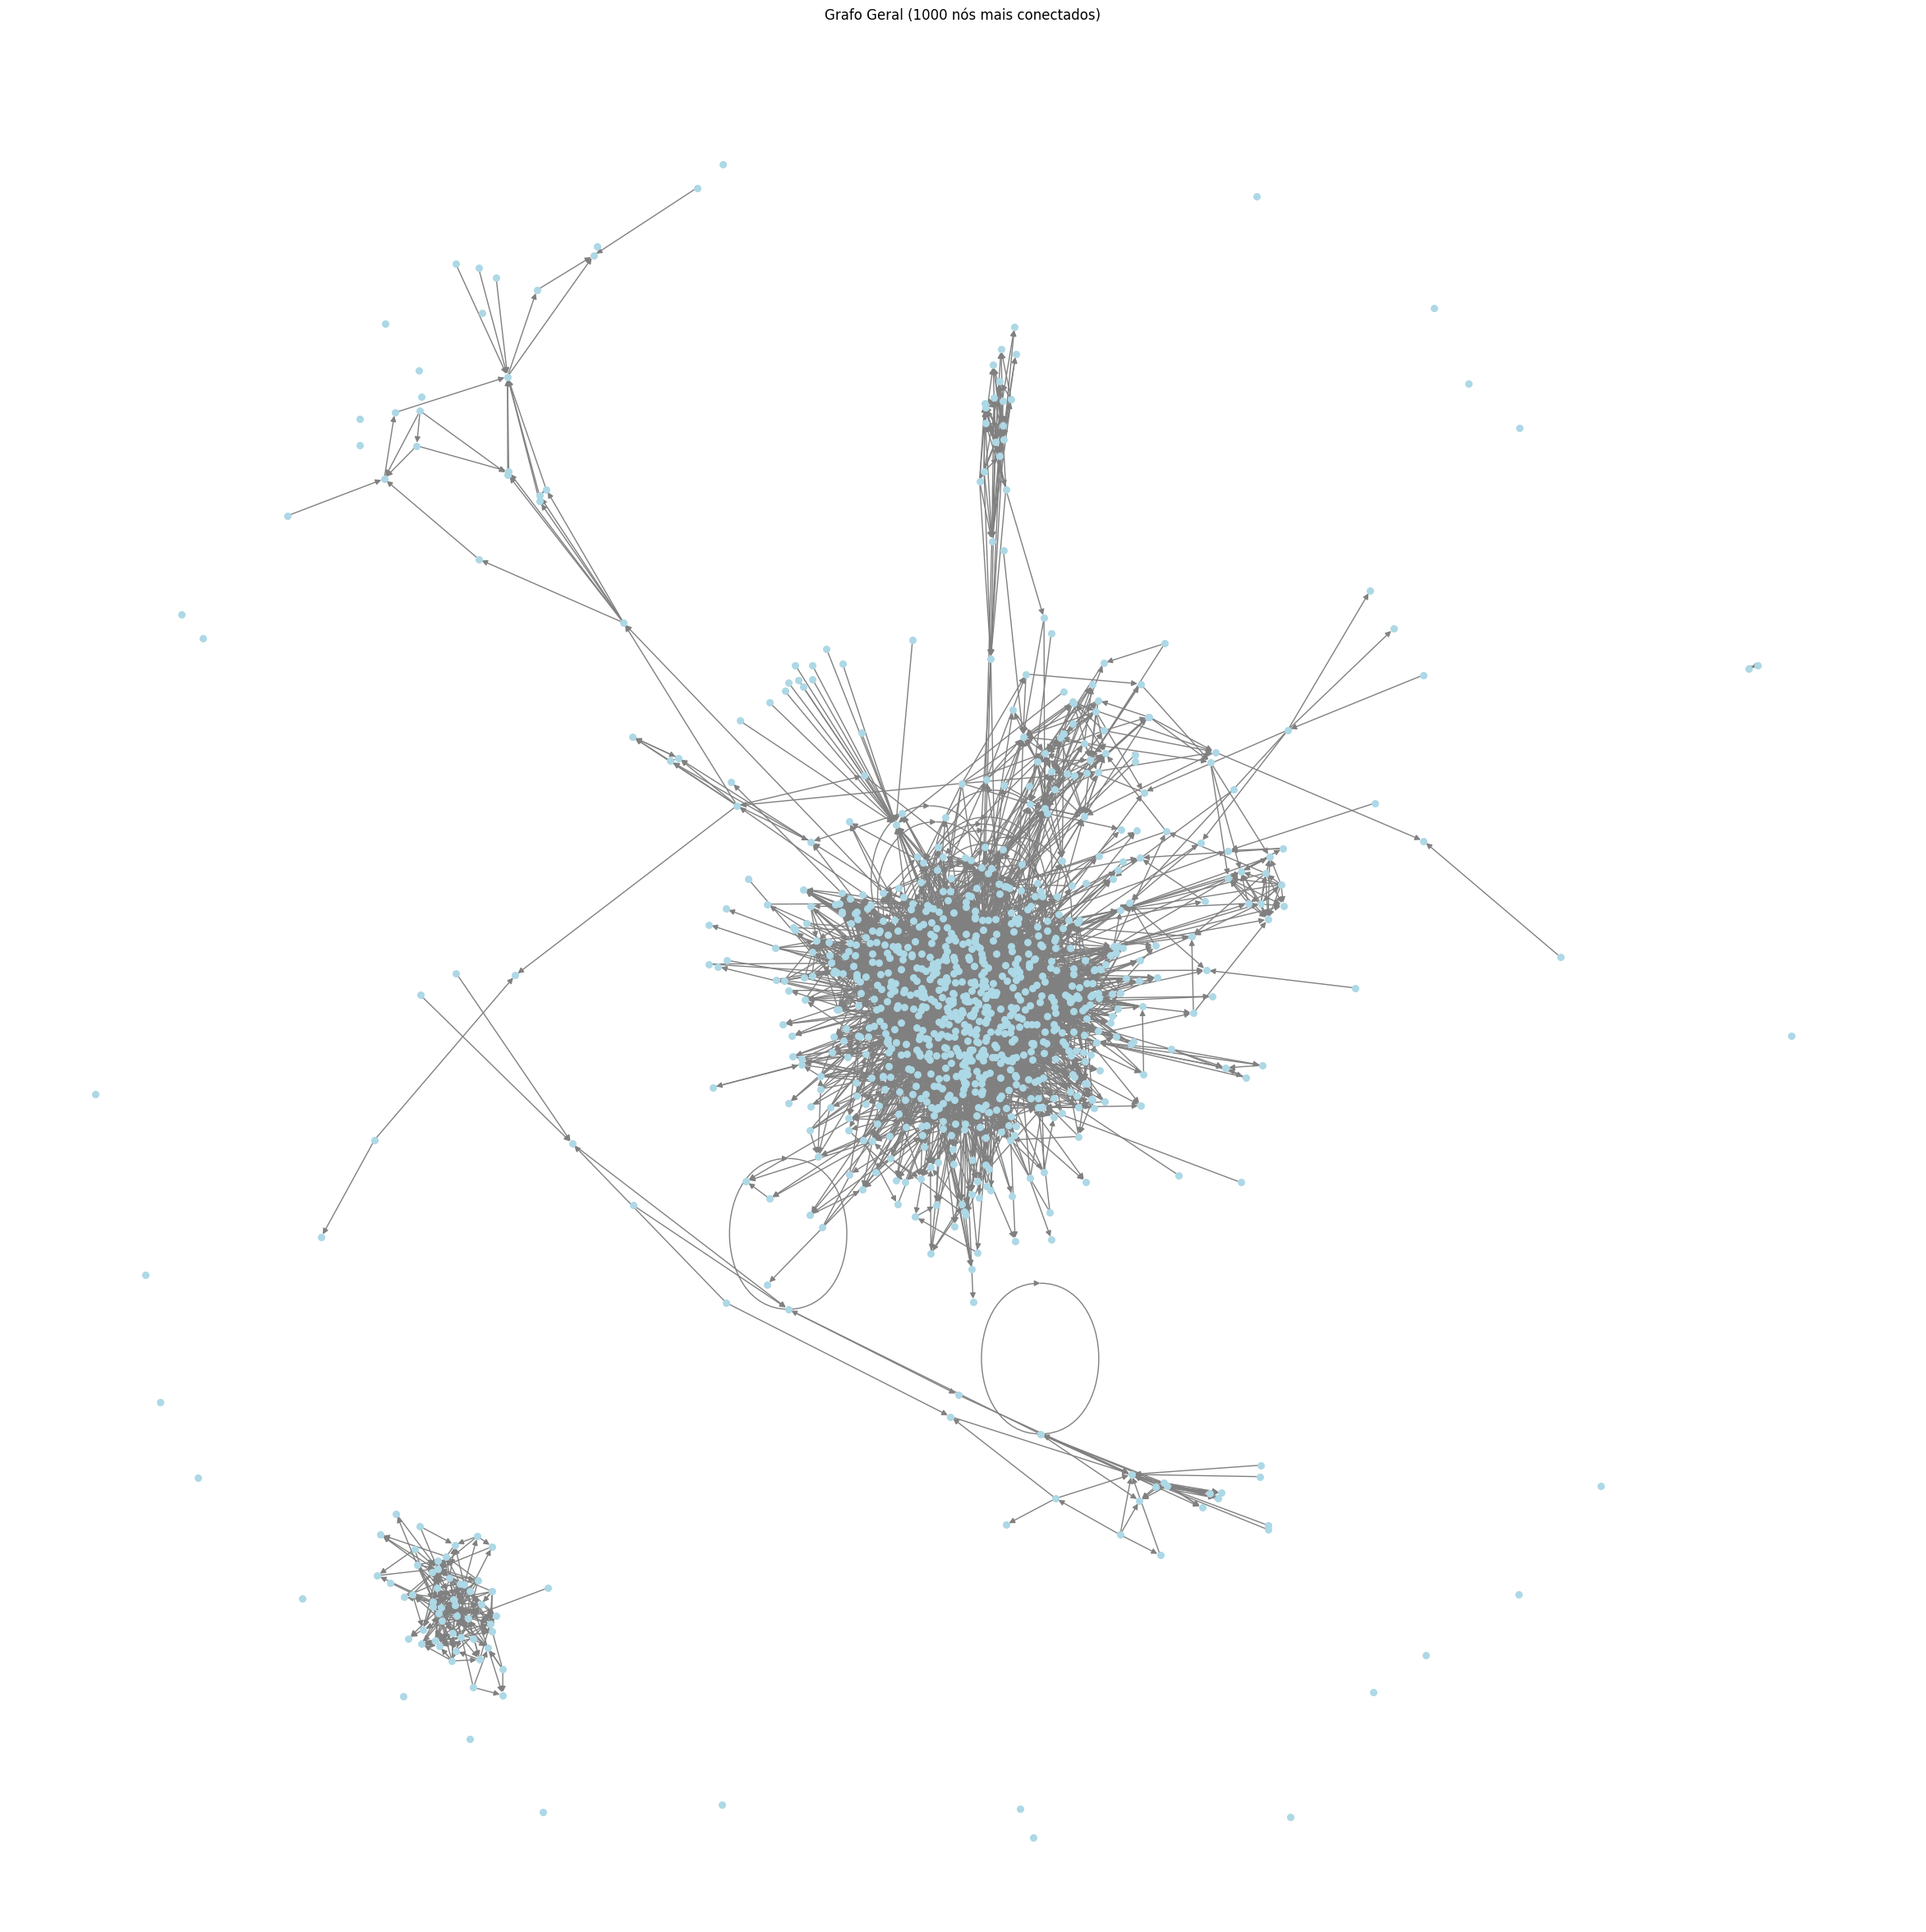

In [19]:
# exibe o plot do grafo geral (aplenas os 100 nos mais conectados) com o networkx
plt.figure(figsize=(30, 30))
plt.title("Grafo Geral (1000 nós mais conectados)")
top_nodes = sorted(graphs["Geral"].degree, key=lambda x: x[1], reverse=True)[:1000]
subgraph = graphs["Geral"].subgraph([node for node, _ in top_nodes])
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, node_size=30, font_size=8, font_color="black", node_color="lightblue", edge_color="gray")
plt.savefig("imgs/graph_general.png", dpi=300, bbox_inches="tight")
plt.show()

Criando grade de 7x3 para 19 grafos


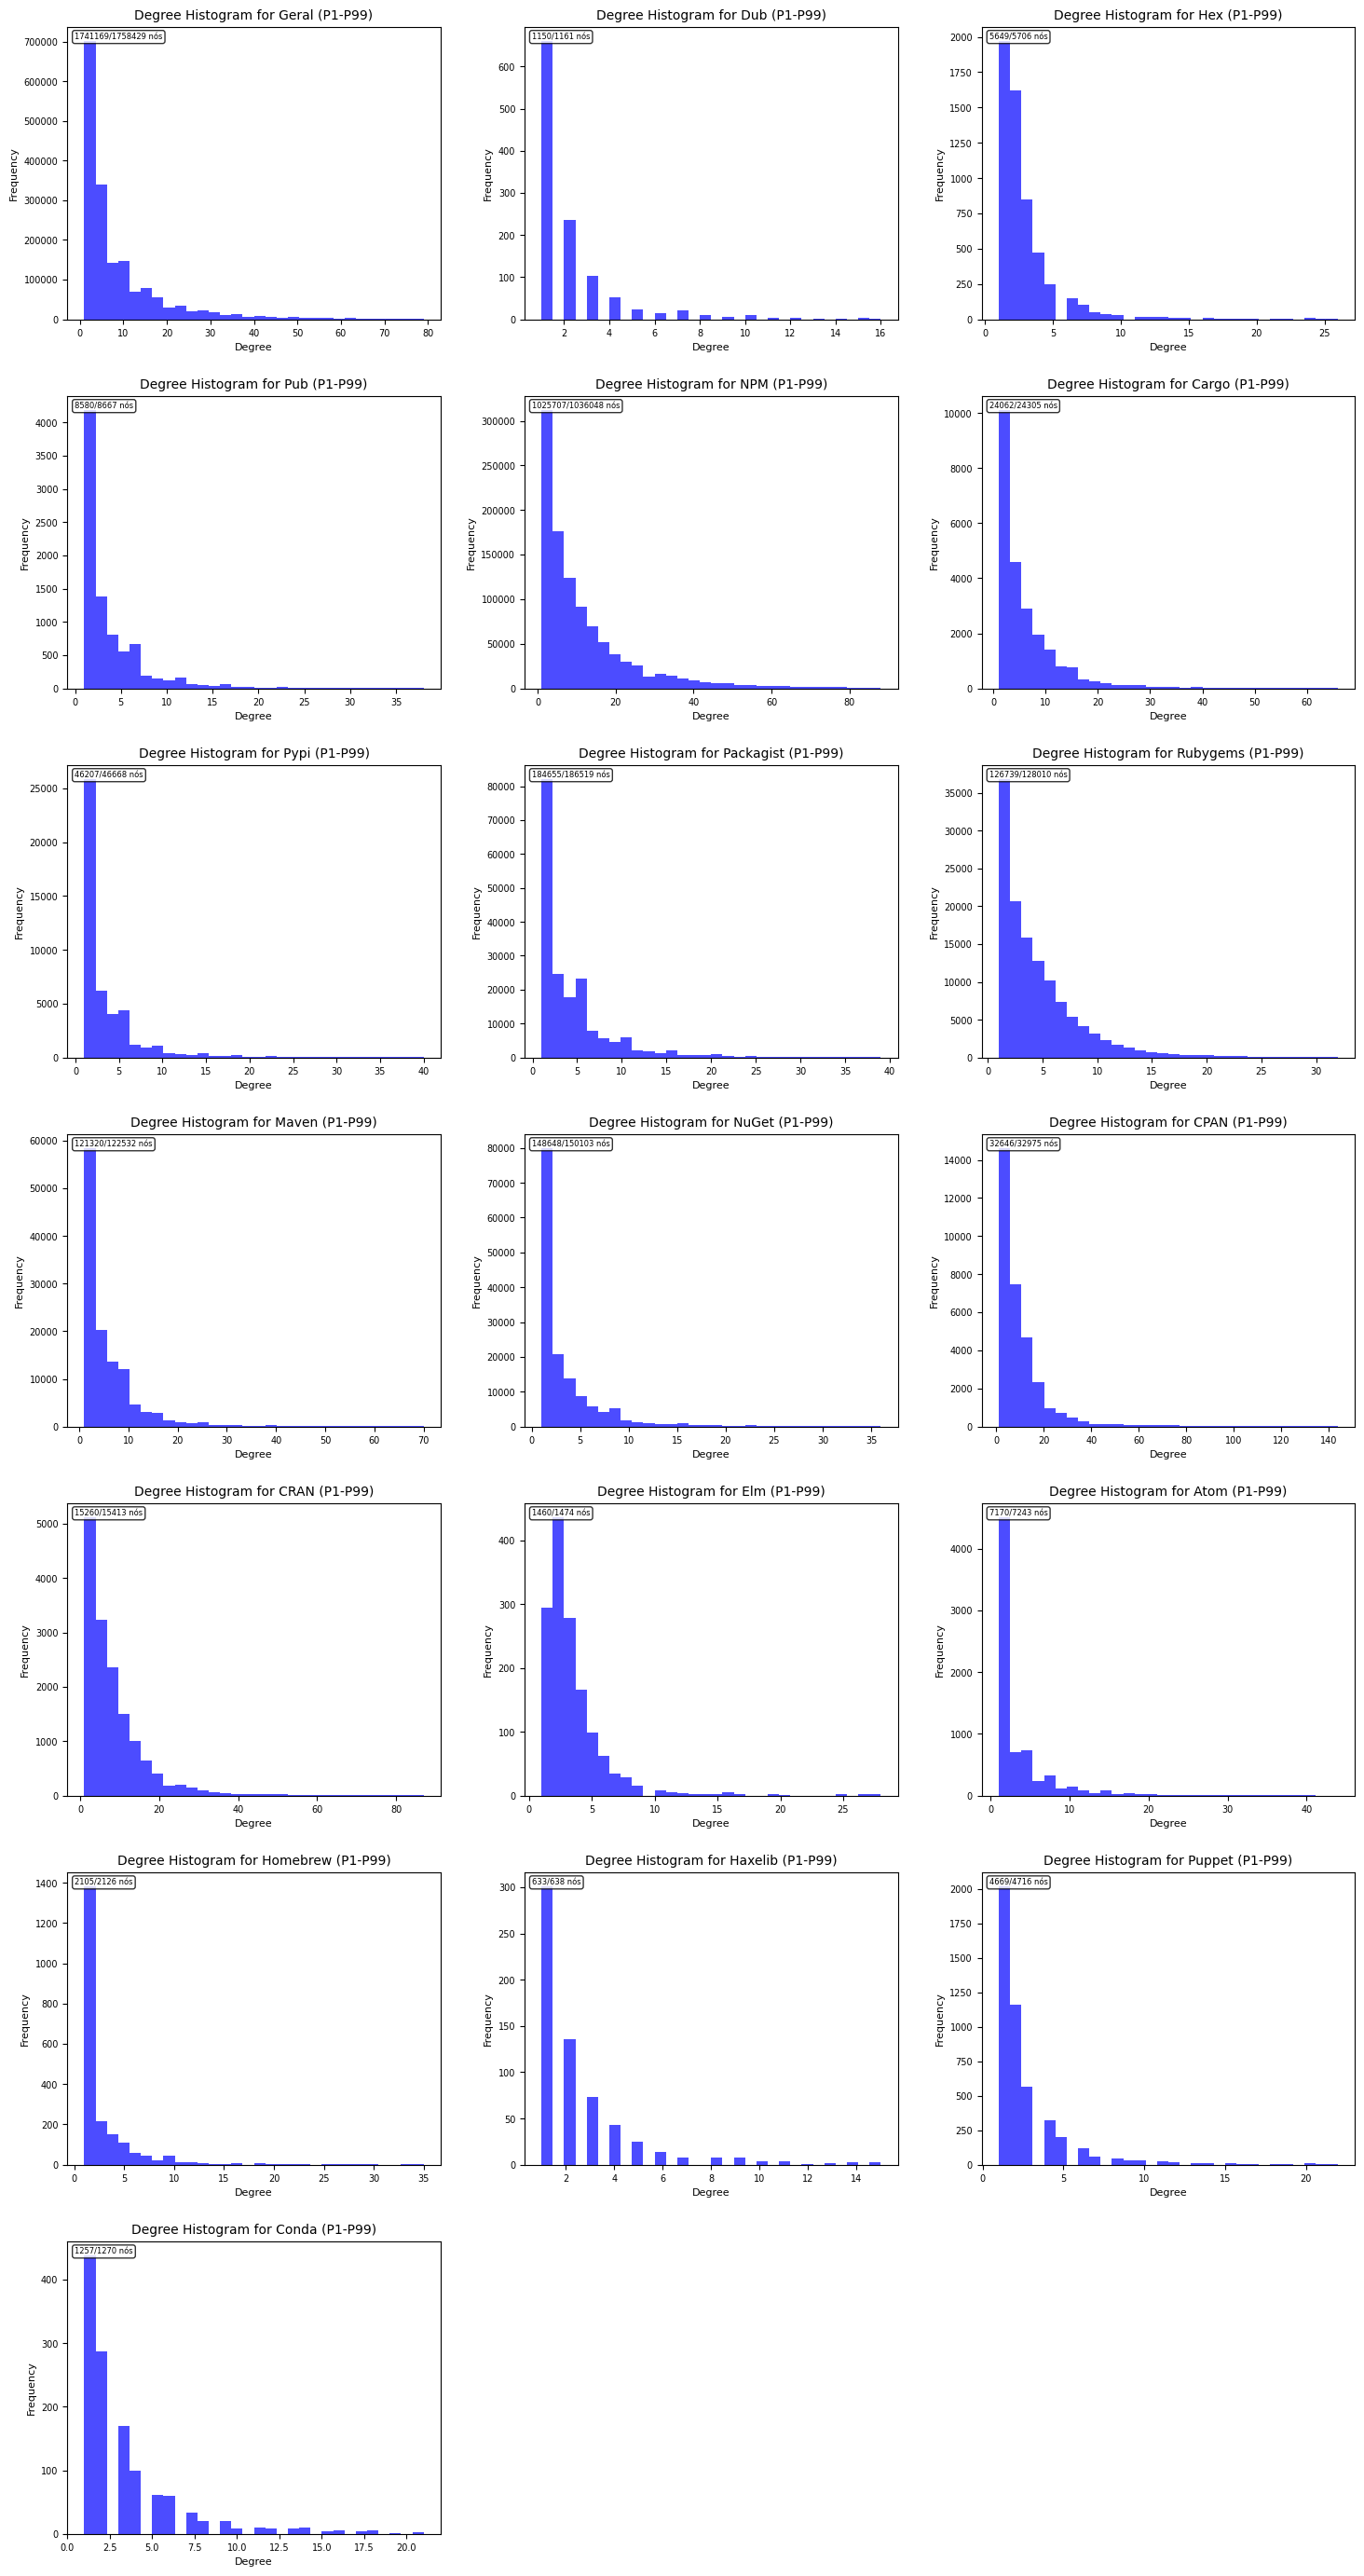


Configurações utilizadas:
- Filtro por percentis: Ativo
- Percentil inferior: 1.0%
- Percentil superior: 99.0%


In [20]:
# Conta quantos grafos existem
num_graphs = len(graphs)

# Calcula automaticamente o número de linhas e colunas necessárias
# Mantém no máximo 3 colunas para melhor legibilidade
cols = 3
rows = math.ceil(num_graphs / cols)

# Ajusta o tamanho da figura baseado no número de linhas
fig_height = max(15, rows * 4)  # Mínimo 15, mas cresce com o número de linhas

print(f"Criando grade de {rows}x{cols} para {num_graphs} grafos")

# --- CONFIGURAÇÕES DE FILTRO ---
# Defina aqui se quer usar filtro por percentis
USE_PERCENTILE_FILTER = True  # Mude para False para usar dados completos
LOWER_PERCENTILE = 0.01  # Percentil inferior (1%)
UPPER_PERCENTILE = 0.99  # Percentil superior (99%)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, fig_height))

# Se só há uma linha, axs não será uma matriz 2D, então precisamos corrigir
if rows == 1:
    axs = axs.reshape(1, -1)

axs = axs.flatten()

# Plota os histogramas
for i, (platform, graph) in enumerate(graphs.items()):
    if i < len(axs):  # Proteção adicional
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)

        # Aplica filtro por percentis se habilitado
        if USE_PERCENTILE_FILTER and len(degree_sequence) > 0:
            lower_bound = np.percentile(degree_sequence, LOWER_PERCENTILE * 100)
            upper_bound = np.percentile(degree_sequence, UPPER_PERCENTILE * 100)
            degree_sequence_filtered = [d for d in degree_sequence if lower_bound <= d <= upper_bound]

            # Usa os dados filtrados se houver elementos, senão usa os originais
            plot_data = degree_sequence_filtered if degree_sequence_filtered else degree_sequence
            title_suffix = f" (P{LOWER_PERCENTILE*100:.0f}-P{UPPER_PERCENTILE*100:.0f})"
        else:
            plot_data = degree_sequence
            title_suffix = " (Dados Completos)"

        axs[i].hist(plot_data, bins=30, color="blue", alpha=0.7)
        axs[i].set_title(f"Degree Histogram for {platform}{title_suffix}", fontsize=10)
        axs[i].set_xlabel("Degree", fontsize=8)
        axs[i].set_ylabel("Frequency", fontsize=8)

        # Ajusta o tamanho da fonte dos números nos eixos
        axs[i].tick_params(axis="both", which="major", labelsize=7)

        # Adiciona informação sobre quantos dados foram filtrados
        if USE_PERCENTILE_FILTER and len(degree_sequence) > 0:
            total_nodes = len(degree_sequence)
            filtered_nodes = len(plot_data)
            axs[i].text(
                0.02, 0.98, f"{filtered_nodes}/{total_nodes} nós", transform=axs[i].transAxes, fontsize=6, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )

# Remove subplots vazios (se houver)
for i in range(num_graphs, len(axs)):
    fig.delaxes(axs[i])

# Ajusta automaticamente o espaçamento para evitar sobreposição
plt.tight_layout(pad=2.0)  # Adiciona mais espaçamento

# Nome do arquivo muda baseado no filtro usado
filename_suffix = f"_P{LOWER_PERCENTILE*100:.0f}-P{UPPER_PERCENTILE*100:.0f}" if USE_PERCENTILE_FILTER else "_completo"
plt.savefig(f"imgs/degree_histograms{filename_suffix}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nConfigurações utilizadas:")
print(f"- Filtro por percentis: {'Ativo' if USE_PERCENTILE_FILTER else 'Inativo'}")
if USE_PERCENTILE_FILTER:
    print(f"- Percentil inferior: {LOWER_PERCENTILE*100:.1f}%")
    print(f"- Percentil superior: {UPPER_PERCENTILE*100:.1f}%")

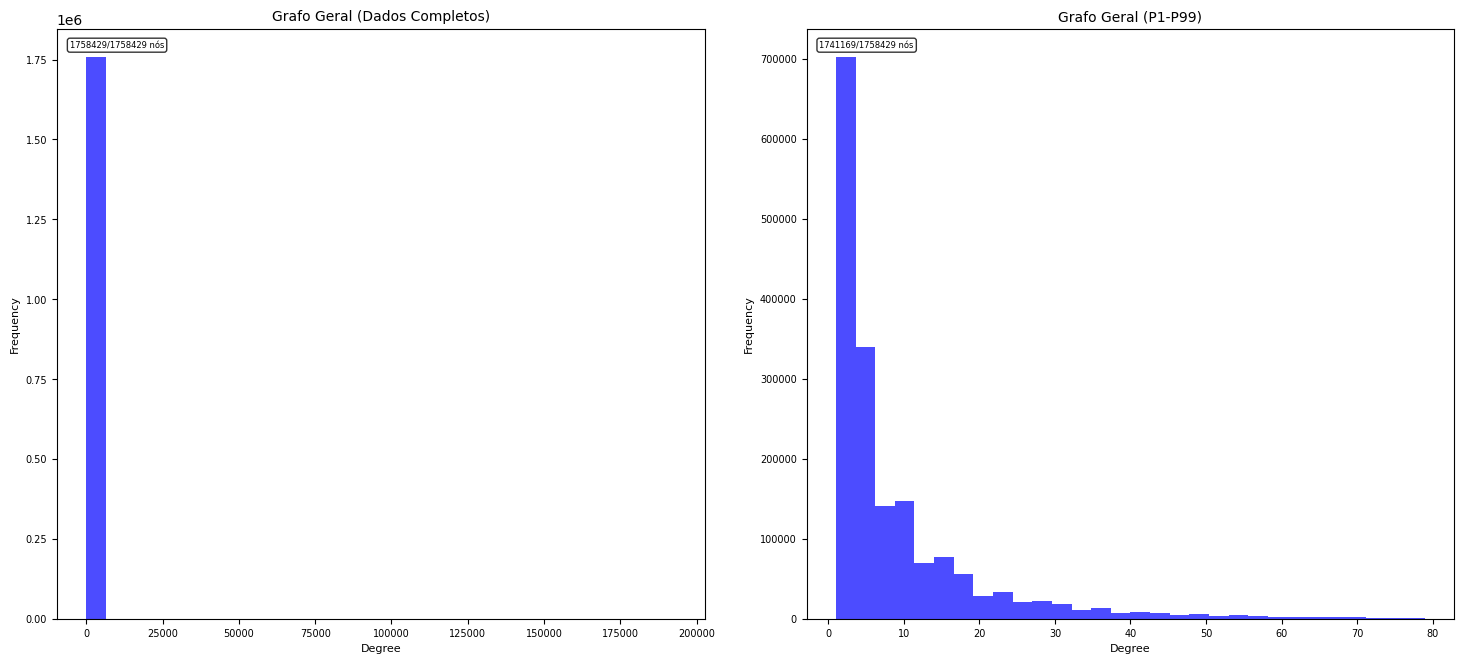

In [21]:
# plota apenas o histograma do grafo geral de um lado do grid sem filtro de percentis e do lado direito com filtro de percentis
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
# Plota o histograma do grafo geral sem filtro de percentis
degree_sequence = sorted([d for n, d in graphs["Geral"].degree()], reverse=True)
axs[0].hist(degree_sequence, bins=30, color="blue", alpha=0.7)
axs[0].set_title("Grafo Geral (Dados Completos)", fontsize=10)
axs[0].set_xlabel("Degree", fontsize=8)
axs[0].set_ylabel("Frequency", fontsize=8)
# Ajusta o tamanho da fonte dos números nos eixos
axs[0].tick_params(axis="both", which="major", labelsize=7)
# Adiciona informação sobre quantos dados foram filtrados
total_nodes = len(degree_sequence)
filtered_nodes = len(degree_sequence)
axs[0].text(0.02, 0.98, f"{filtered_nodes}/{total_nodes} nós", transform=axs[0].transAxes, fontsize=6, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
# Configurações de percentis

LOWER_PERCENTILE = 0.01  # Percentil inferior (1%)
UPPER_PERCENTILE = 0.99  # Percentil superior (99%)

# Plota o histograma do grafo geral com filtro de percentis
lower_bound = np.percentile(degree_sequence, LOWER_PERCENTILE * 100)
upper_bound = np.percentile(degree_sequence, UPPER_PERCENTILE * 100)
degree_sequence_filtered = [d for d in degree_sequence if lower_bound <= d <= upper_bound]
# Usa os dados filtrados se houver elementos, senão usa os originais
plot_data = degree_sequence_filtered if degree_sequence_filtered else degree_sequence
title_suffix = f" (P{LOWER_PERCENTILE*100:.0f}-P{UPPER_PERCENTILE*100:.0f})"
axs[1].hist(plot_data, bins=30, color="blue", alpha=0.7)
axs[1].set_title(f"Grafo Geral{title_suffix}", fontsize=10)
axs[1].set_xlabel("Degree", fontsize=8)
axs[1].set_ylabel("Frequency", fontsize=8)
# Ajusta o tamanho da fonte dos números nos eixos
axs[1].tick_params(axis="both", which="major", labelsize=7)
# Adiciona informação sobre quantos dados foram filtrados
if USE_PERCENTILE_FILTER and len(degree_sequence) > 0:
    total_nodes = len(degree_sequence)
    filtered_nodes = len(plot_data)
    axs[1].text(0.02, 0.98, f"{filtered_nodes}/{total_nodes} nós", transform=axs[1].transAxes, fontsize=6, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
# Ajusta automaticamente o espaçamento para evitar sobreposição
plt.tight_layout(pad=2.0)  # Adiciona mais espaçamento
# Nome do arquivo muda baseado no filtro usado
filename_suffix = f"_P{LOWER_PERCENTILE*100:.0f}-P{UPPER_PERCENTILE*100:.0f}" if USE_PERCENTILE_FILTER else "_completo"
plt.savefig(f"imgs/degree_histogram_general{filename_suffix}.png", dpi=300, bbox_inches="tight")
plt.show()

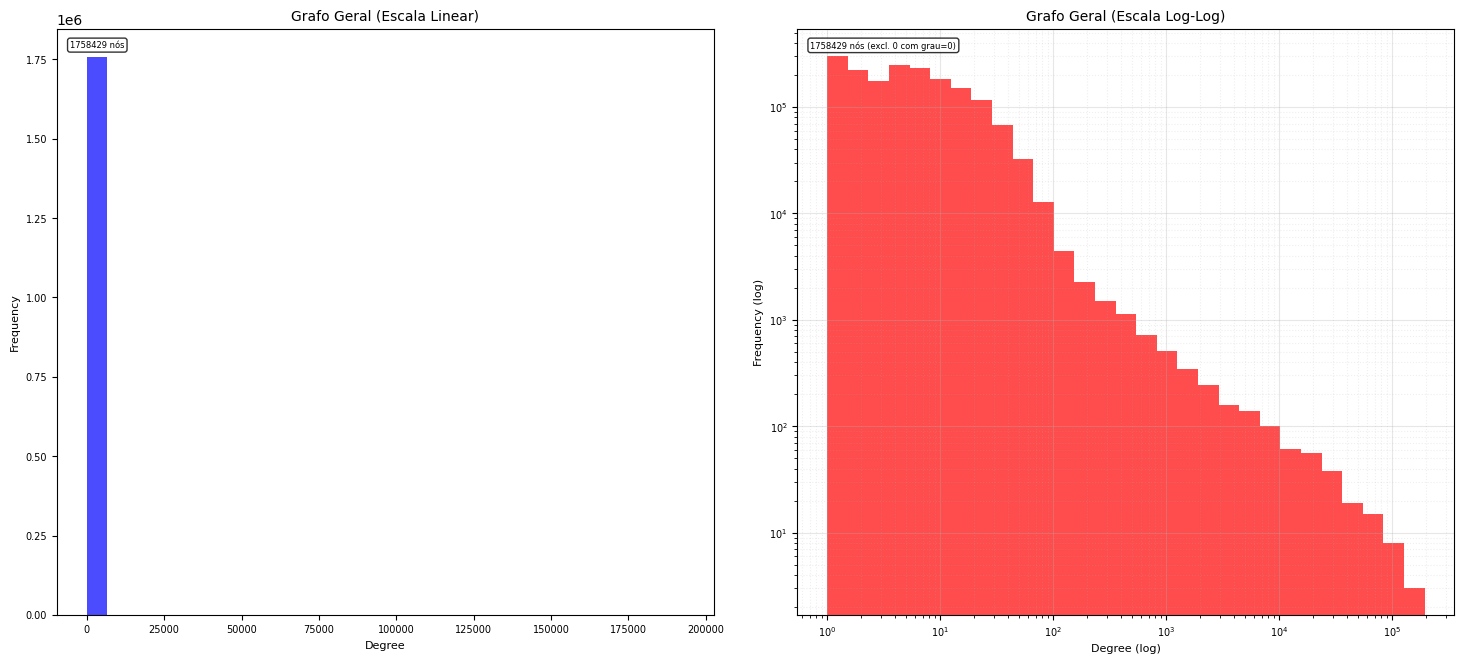

In [22]:
# plota apenas o histograma do grafo geral de um lado do grid sem filtro de percentis e do lado direito com escala log-log
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plota o histograma do grafo geral sem filtro de percentis (lado esquerdo)
degree_sequence = sorted([d for n, d in graphs["Geral"].degree()], reverse=True)
axs[0].hist(degree_sequence, bins=30, color="blue", alpha=0.7)
axs[0].set_title("Grafo Geral (Escala Linear)", fontsize=10)
axs[0].set_xlabel("Degree", fontsize=8)
axs[0].set_ylabel("Frequency", fontsize=8)
# Ajusta o tamanho da fonte dos números nos eixos
axs[0].tick_params(axis="both", which="major", labelsize=7)
# Adiciona informação sobre quantos dados foram filtrados
total_nodes = len(degree_sequence)
axs[0].text(0.02, 0.98, f"{total_nodes} nós", transform=axs[0].transAxes, fontsize=6, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Cria bins em escala logarítmica
min_degree = min(degree_sequence)
max_degree = max(degree_sequence)
log_bins = np.logspace(np.log10(min_degree), np.log10(max_degree), 30)

# Plota o histograma com escala log-log
counts, bins, patches = axs[1].hist(degree_sequence, bins=log_bins, color="red", alpha=0.7)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_title("Grafo Geral (Escala Log-Log)", fontsize=10)
axs[1].set_xlabel("Degree (log)", fontsize=8)
axs[1].set_ylabel("Frequency (log)", fontsize=8)

# Ajusta o tamanho da fonte dos números nos eixos
axs[1].tick_params(axis="both", which="major", labelsize=7)
axs[1].tick_params(axis="both", which="minor", labelsize=6)

# Adiciona grid para melhor visualização na escala log
axs[1].grid(True, which="major", ls="-", alpha=0.3)
axs[1].grid(True, which="minor", ls=":", alpha=0.2)

# Adiciona informação sobre os dados
nodes_nonzero = len(degree_sequence)
nodes_zero = total_nodes - nodes_nonzero
axs[1].text(
    0.02,
    0.98,
    f"{nodes_nonzero} nós (excl. {nodes_zero} com grau=0)",
    transform=axs[1].transAxes,
    fontsize=6,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

# Ajusta automaticamente o espaçamento para evitar sobreposição
plt.tight_layout(pad=2.0)

# salva e exibe
plt.savefig("imgs/degree_histogram_general_linear_vs_loglog.png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
# Análise Completa Unificada (Métricas Básicas + Diâmetro + Centralidade)

# Carrega o DataFrame principal uma única vez
df = pd.read_parquet("DB/List-dependencies.parquet")

# Define diretórios temporários e de saída
temp_data_dir = "temp"
output_dir = "reports"
os.makedirs(temp_data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print(f"Salvando arquivos de dados temporários em: '{os.path.abspath(temp_data_dir)}'")
print(f"Os relatórios finais serão salvos em: '{os.path.abspath(output_dir)}'")

# Cria uma lista de todas as plataformas para processar
platforms_to_process = ["Geral"] + list(df["Platform"].unique())

# Salva cada fatia do DataFrame como um arquivo Parquet separado
tasks_to_run = []
for name in platforms_to_process:
    file_path = os.path.join(temp_data_dir, f"{name}.parquet")
    if name == "Geral":
        df.to_parquet(file_path)
    else:
        # Filtra e salva o DataFrame da plataforma
        platform_df = df[df["Platform"] == name]
        platform_df.to_parquet(file_path)

    tasks_to_run.append({"name": name, "path": file_path})

print(f"{len(tasks_to_run)} arquivos de dados foram preparados.")

# --- Orquestração: Lançar Processos Analisadores Unificados ---

# Limitar o número de processos simultâneos ainda é crucial
MAX_PROCESSES = 12
print(f"\n🚀 Iniciando análise completa com no máximo {MAX_PROCESSES} processos paralelos...")

processes = []
task_queue = list(tasks_to_run)  # Fila de tarefas
completed_tasks = []

# Configuração da barra de progresso bonita
progress_bar = tqdm(
    total=len(task_queue), desc="🔍 Analisando grafos", unit="grafo", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]", colour="green"
)

try:
    while task_queue or processes:
        # Lança novos processos se houver espaço e tarefas
        while len(processes) < MAX_PROCESSES and task_queue:
            task = task_queue.pop(0)
            # Usando o arquivo unificado graph_analyzer.py
            command = ["python", "graph_analyzer.py", task["path"], task["name"], output_dir]
            # Inicia o processo sem bloquear e esconde a janela do console no Windows
            proc = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, creationflags=subprocess.CREATE_NO_WINDOW)
            processes.append((proc, task["name"]))

            # Atualiza a descrição da barra com a tarefa atual
            progress_bar.set_description(f"🔍 Processando: {task['name']}")

        # Verifica os processos em execução
        for proc, name in list(processes):  # Cria cópia da lista para modificação segura
            if proc.poll() is not None:  # Processo terminou
                stdout, stderr = proc.communicate()
                if proc.returncode != 0:
                    # Silencia os prints durante a barra de progresso
                    completed_tasks.append(f"❌ ERRO em '{name}': {stderr.decode('utf-8', errors='ignore')[:100]}...")
                else:
                    completed_tasks.append(f"✅ {name}")

                processes.remove((proc, name))
                progress_bar.update(1)  # Atualiza a barra de progresso

        # Pequena pausa para não sobrecarregar a CPU com o loop de verificação
        time.sleep(0.1)  # Reduzido para mais responsividade

finally:
    progress_bar.close()

# Agora mostra todos os resultados de uma vez
print(f"\n📊 Resumo da execução:")
print("=" * 60)
for task_result in completed_tasks:
    print(f"  {task_result}")
print("=" * 60)

print("\n--- Análise completa de todos os grafos concluída! ---")
print(f"Relatórios salvos em: {os.path.abspath(output_dir)}")

# Opcional: Limpar os arquivos temporários
# import shutil
# shutil.rmtree(temp_data_dir)
# print("Diretório de dados temporários removido.")

Salvando arquivos de dados temporários em: 'c:\Users\samuelcosta\Documents\cr-ufabc\temp'
Os relatórios finais serão salvos em: 'c:\Users\samuelcosta\Documents\cr-ufabc\reports'
19 arquivos de dados foram preparados.

🚀 Iniciando análise completa com no máximo 12 processos paralelos...
19 arquivos de dados foram preparados.

🚀 Iniciando análise completa com no máximo 12 processos paralelos...


🔍 Processando: Conda: 100%|████████████████████████████████| 19/19 [19:50:16<00:00, 3758.74s/grafo]


📊 Resumo da execução:
  ✅ Dub
  ✅ Hex
  ✅ Elm
  ✅ Pub
  ✅ Homebrew
  ✅ Haxelib
  ✅ Atom
  ✅ Conda
  ✅ Puppet
  ✅ CRAN
  ✅ Cargo
  ✅ Pypi
  ✅ CPAN
  ✅ NuGet
  ✅ Maven
  ✅ Geral
  ✅ Packagist
  ✅ Rubygems
  ✅ NPM

--- Análise completa de todos os grafos concluída! ---
Relatórios salvos em: c:\Users\samuelcosta\Documents\cr-ufabc\reports


In [25]:
# Análise Rápida de Diâmetro - Teste Direto nos Grafos Carregados

# Importa as funções do arquivo externo unificado
from graph_analyzer import approximate_diameter_optimized

print("🎯 ANÁLISE RÁPIDA DE DIÂMETRO PARA TODOS OS GRAFOS\n")

# Análise direta nos grafos já carregados na memória
results_summary = []
graph_names = list(graphs.keys())

# Barra de progresso bonita para a análise rápida
progress_bar = tqdm(graph_names, desc="⚡ Calculando diâmetros", unit="grafo", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]", colour="blue")

for name in progress_bar:
    graph = graphs[name]
    progress_bar.set_description(f"⚡ Analisando: {name}")

    start_time = time.time()
    result = approximate_diameter_optimized(graph)

    if result:
        diameter, component_size, method, _ = result
        elapsed = time.time() - start_time

        result_data = {
            "Platform": name,
            "Nodes": graph.number_of_nodes(),
            "Edges": graph.number_of_edges(),
            "Diameter": diameter,
            "Method": method,
            "Component_Size": component_size,
            "Component_Percent": (component_size / graph.number_of_nodes()) * 100,
            "Time_seconds": elapsed,
        }

        results_summary.append(result_data)

    # Pequena pausa para visualizar melhor o progresso
    time.sleep(0.1)

progress_bar.close()

# Mostra resumo dos resultados calculados
print(f"\n📊 Processamento concluído! Calculados {len(results_summary)} diâmetros com sucesso.")

print(f"\n📈 RESUMO CONSOLIDADO")
print("=" * 65)

# Cria DataFrame com resultados
results_df = pd.DataFrame(results_summary)

# Ordena por diâmetro
results_df = results_df.sort_values("Diameter", ascending=True)

# Tabela formatada mais bonita
print(f"\n{'🏷️ Platform':<17} {'📊 Nós':<12} {'🔍 Diâmetro':<12} {'📈 Comp.%':<10} {'⏱️ Tempo':<8}")
print("─" * 65)

for _, row in results_df.iterrows():
    print(f"{row['Platform']:<15} {row['Nodes']:<10,} {row['Diameter']:<10} {row['Component_Percent']:<7.1f}% {row['Time_seconds']:<5.1f}s")

print("─" * 65)

# Salva resultados em arquivo
results_df.to_csv("reports/diametros_resumo.csv", index=False)
print(f"\n💾 Resultados salvos em: reports/diametros_resumo.csv")

# Análise estatística rápida com emojis
print(f"\n📊 ESTATÍSTICAS DOS DIÂMETROS")
print("─" * 35)
diameters = results_df["Diameter"].values
print(f"🔹 Menor diâmetro:   {min(diameters)}")
print(f"🔸 Maior diâmetro:   {max(diameters)}")
print(f"📏 Diâmetro médio:   {np.mean(diameters):.1f}")
print(f"🎯 Diâmetro mediano: {np.median(diameters):.1f}")

# Destaque das plataformas
print(f"\n🎖️ DESTAQUES")
print("─" * 20)
print(f"🥇 Menor diâmetro: {results_df.iloc[0]['Platform']} (diâmetro = {results_df.iloc[0]['Diameter']})")
print(f"📐 Maior diâmetro: {results_df.iloc[-1]['Platform']} (diâmetro = {results_df.iloc[-1]['Diameter']})")

🎯 ANÁLISE RÁPIDA DE DIÂMETRO PARA TODOS OS GRAFOS



⚡ Analisando: Conda: 100%|██████████████████████████████████████| 19/19 [01:35<00:00,  5.00s/grafo]


📊 Processamento concluído! Calculados 19 diâmetros com sucesso.

📈 RESUMO CONSOLIDADO

🏷️ Platform       📊 Nós        🔍 Diâmetro   📈 Comp.%   ⏱️ Tempo
─────────────────────────────────────────────────────────────────
Dub             1,161      0          0.1    % 0.0  s
Elm             1,474      0          0.1    % 0.0  s
Homebrew        2,126      0          0.0    % 0.0  s
Atom            7,243      0          0.0    % 0.0  s
Conda           1,270      0          0.1    % 0.0  s
Haxelib         638        1          0.3    % 0.0  s
Puppet          4,716      1          0.0    % 0.0  s
Hex             5,706      2          0.1    % 0.0  s
Pypi            46,668     3          0.0    % 0.3  s
NuGet           150,103    5          0.0    % 0.9  s
Pub             8,667      8          0.7    % 0.1  s
CPAN            32,975     12         1.3    % 1.1  s
Packagist       186,519    14         0.2    % 1.5  s
CRAN            15,413     17         5.7    % 0.9  s
Rubygems        128,010   